### nb used to test honey detection

In [1]:
import os, multiprocessing, glob
import matplotlib.pyplot as plt
import cv2 as cv2
import numpy as np
from tqdm import tqdm
from libvisu import *
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set a wide width for display
pd.set_option('display.colheader_justify', 'center')  # Align column headers

## Configuration

In [2]:
# Path to the folder containing the pictures
rootpath_imgs = '/Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/24.11_aSensing_OH/Images/'                                 # For images
rootpath_data = '/Users/cyrilmonette/Desktop/EPFL 2018-2026/PhD - Mobots/ABC/ABCVisualisation/data/2025-03-14_18-00_influxdb_data.csv'  # For CO2, htr and tmp data
hive_nb = "1"
t_res = "1min" # Image time resolution. Change only if images are not taken every minute. Use frame_drop to keep only some frames, not this.

first_dt = "241102-120000Z"
last_dt = "241104-120000Z"
frame_drop = 10 # We keep 1 frame every frame_drop frames. Put one to keep all frames.

### images fetching

In [3]:
# Try to create a hive with no CO2 and thermal data
# Get the target dt (for which we need an image, data, etc.)
datetimes = pd.date_range(start=pd.to_datetime(first_dt, format='%y%m%d-%H%M%S%z'), end=pd.to_datetime(last_dt, format='%y%m%d-%H%M%S%z'), freq=t_res)
datetimes = datetimes[::frame_drop]

imgs_paths = fetchImagesPaths(rootpath_imgs, datetimes, hive_nb)

Missing images before filtering:  0 out of 1156 images.


### tmp fetching

In [4]:
# We fetch the thermal and other sensory data from the hive, for both RPis.
all_data = prepareData(rootpath_data)                   # All data in the csv nicely formatted
hive_data = extractData(all_data, int(hive_nb), datetimes) # Restricted to our time frame and hive
upper, lower = generateThermalDF(hive_data,datetimes)   # Only tmp data, in a format that can be used by ThermalFrame
# Seek the max and min values of the tmp data, in both upper and lower hives
max_temp = max(upper.max().max(), lower.max().max())
min_temp = min(upper.min().min(), lower.min().min())
print("Max temperature in the selected time range: ", max_temp)
print("Min temperature in the selected time range: ", min_temp)
print(upper)

Max temperature in the selected time range:  35.252604166666664
Min temperature in the selected time range:  16.451953125
                              t00        t01        t02        t03        t04        t05        t06        t07        t08        t09        t10        t11        t12        t13        t14        t15        t16        t17        t18        t19        t20        t21        t22        t23        t24        t25        t26        t27        t28        t29        t30        t31        t32        t33        t34        t35        t36        t37        t38        t39        t40        t41        t42        t43        t44        t45        t46        t47        t48        t49        t50        t51        t52        t53        t54        t55        t56        t57        t58        t59        t60        t61        t62        t63   
2024-11-02 12:00:00+00:00  22.502604  22.003906  21.708333  21.665365  22.361979  22.800781  23.217448  22.613281  23.514323  24.597656  22.365885  

### htr fetching

In [5]:
# Alternative used now:
upper_htr = hive_data[(hive_data["inhive_loc"] == "upper") & (hive_data["_measurement"] == "htr")]
lower_htr = hive_data[(hive_data["inhive_loc"] == "lower") & (hive_data["_measurement"] == "htr")]
# Drop the _measurement column
upper_htr = upper_htr.drop(columns=["_measurement"])
lower_htr = lower_htr.drop(columns=["_measurement"])
print(upper_htr)

                                    _time             _value     _field  board_id  hive_num inhive_loc          mcu_uuid           rpi_num valid  DeltaT actuator_instance content  filling_density
_time                                                                                                                                                                                              
2024-11-02 12:00:00+00:00 2024-11-02 12:00:00+00:00  22.632810  avg_temp   abc04       1       upper    3475729523041250812900914     1      NaN    0.0          h04        Unknown      Unknown   
2024-11-02 12:00:00+00:00 2024-11-02 12:00:00+00:00   0.000000       pwm   abc04       1       upper    3475729523041250812900914     1      NaN    0.0          h02        Unknown      Unknown   
2024-11-02 12:00:00+00:00 2024-11-02 12:00:00+00:00  21.979163  avg_temp   abc04       1       upper    3475729523041250812900914     1      NaN    0.0          h01        Unknown      Unknown   
2024-11-02 12:00:00+

### CO2 fetching

In [6]:
# Now we fetch the metabolic data
co2_data =generateMetabolicDF(hive_data)
print(co2_data)

                               ul           ur           ll           lr     
_time                                                                        
2024-11-02 12:00:00+00:00  3988.661000   968.500000  3206.427600   768.833333
2024-11-02 12:10:00+00:00  3745.198167  1359.833333  5441.802833   948.333333
2024-11-02 12:20:00+00:00  2753.693833   972.333333  5313.586200   961.833333
2024-11-02 12:30:00+00:00  2279.904333  1466.333333  5037.258889   946.166667
2024-11-02 12:40:00+00:00  2113.324167   720.166667  3975.799500   853.333333
...                                ...          ...          ...          ...
2024-11-04 11:20:00+00:00  2726.607667  1066.500000  2002.845333   840.500000
2024-11-04 11:30:00+00:00  2697.897333  1555.000000  2245.671667  1033.333333
2024-11-04 11:40:00+00:00  2897.875500  1487.500000  2405.724273  1124.500000
2024-11-04 11:50:00+00:00  3911.509167  2447.500000  3229.919333  1309.333333
2024-11-04 12:00:00+00:00  3758.549500  3331.000000  3225.399167

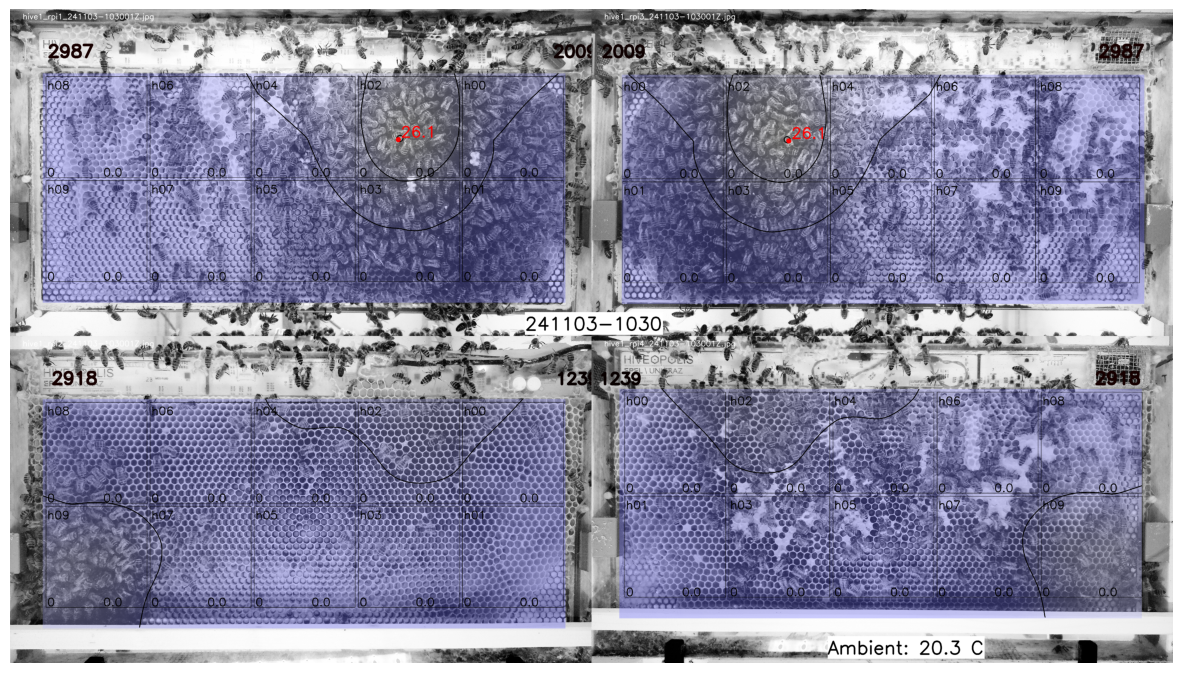

In [14]:
vmax = max_temp
vmin = min_temp
frame = 135 # Frame within datetimes
dt = datetimes[frame]

_imgs_paths = imgs_paths.loc[dt].to_numpy()
imgs_names = [str(_imgs_paths[i]).split("/")[-1] for i in range(len(_imgs_paths))]
# Read the images using cv2
current_imgs = [cv2.imread(_imgs_paths[i], cv2.IMREAD_GRAYSCALE) if _imgs_paths[i] is not None else np.zeros((2592,4608), np.uint8) for i in range(len(_imgs_paths))]
upper_tf = ThermalFrame(upper.loc[dt].to_numpy())
lower_tf = ThermalFrame(lower.loc[dt].to_numpy())

hive = Hive(current_imgs, imgs_names, upper_tf, lower_tf, co2_data.loc[dt], upper_htr.loc[dt], lower_htr.loc[dt])
#hive = Hive(current_imgs, imgs_names, upper_tf, None, None, None, None)

ts = [(260,510),(260,500),(240,520),(220,420)]
hive.setThermalShifts(ts)

contours = list(range(6, 32, 2))
snapshot = hive.snapshot(v_max=vmax,v_min=vmin,contours=contours,thermal_transparency=0.35)
plt.figure(figsize=(15, 10))

plt.imshow(snapshot,cmap='gray')
plt.axis('off') 
plt.show()

4
10
(800, 800)


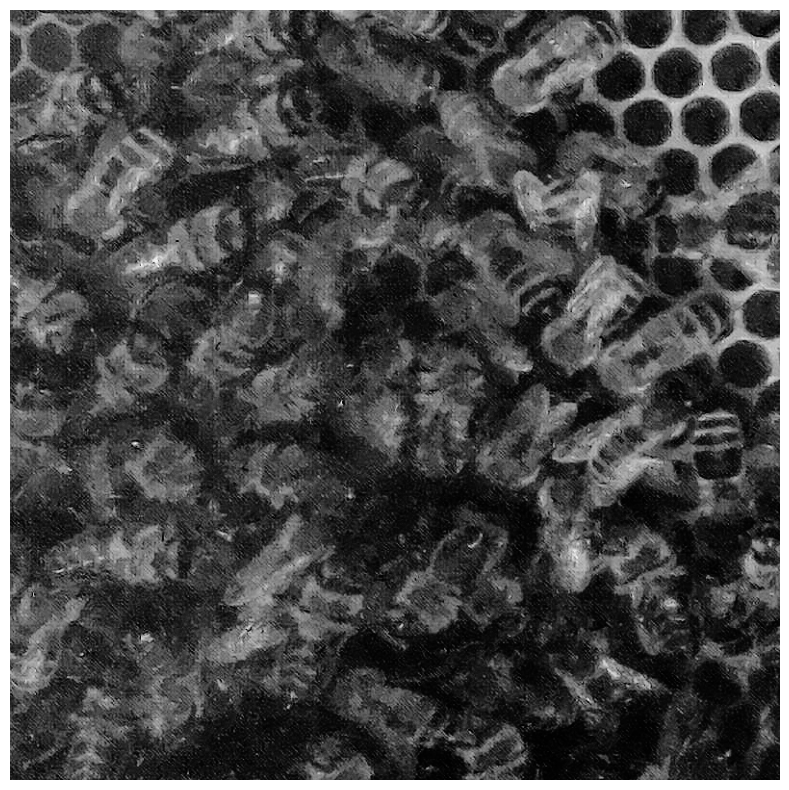

In [26]:
# From hive.htr_pos, we can get the position of the heaters. Use the latter to extract an image per RPi of the heaters
htr_images = {}
for i in range(len(hive.htr_pos)):
    htr_images[i] = {}
    for j in range(len(hive.htr_pos[i])):
        # Cut in hive.pp_imgs[i] the rectangle given by hive.htr_pos[i][f'h{j:02d}']. The rectangle has one tuple for top left corner and one for bottom right corner.
        htr_images[i][f'h{j:02d}'] = hive.pp_imgs[i][hive.htr_pos[i][f'h{j:02d}'][0][1]:hive.htr_pos[i][f'h{j:02d}'][1][1], hive.htr_pos[i][f'h{j:02d}'][0][0]:hive.htr_pos[i][f'h{j:02d}'][1][0]]


print(len(htr_images))
print(len(htr_images[0]))
print(htr_images[0]["h00"].shape)
# plot the image corresponding to the RPi2 view of h09
plt.figure(figsize=(15, 10))
plt.imshow(htr_images[1]["h09"],cmap='gray')
plt.axis('off')
plt.show()
